# 使用conv1d來實踐股票預測
前面我們使用LSTM來建立股票預測模型，現在換成使用conv1d來實驗看看效果。

In [4]:
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Step 0. Loading dataset

In [5]:
tesla_stocks = pd.read_csv('Data/tesla_stocks.csv')

In [6]:
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,4-Aug-14,234.38,240.50,233.27,238.52,5967406
1,5-Aug-14,237.47,242.99,235.69,238.49,5388581
2,6-Aug-14,238.90,251.42,238.58,248.93,9249265
3,7-Aug-14,250.12,256.69,249.12,252.39,7478926
4,8-Aug-14,251.16,251.76,246.50,248.13,5099061


In [7]:
data_to_use = tesla_stocks['Close'].values

In [8]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1. Data preprocessing

#### Step 1.1 Scaling data

In [9]:
scaler = StandardScaler()

In [10]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

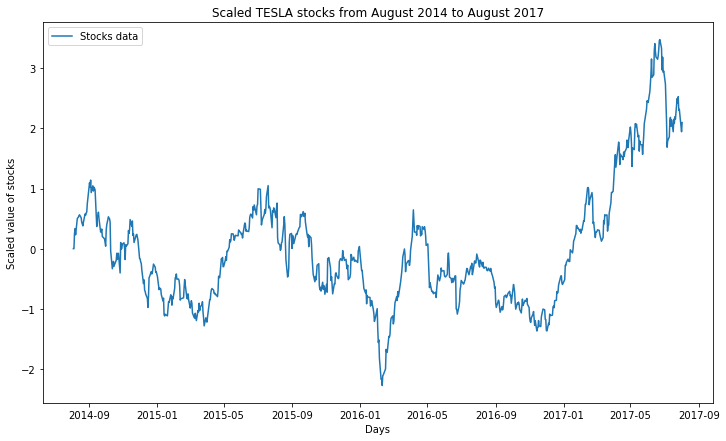

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date, scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [12]:
def window_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    assert len(X) == len(y)
    return X, y

#### Step 1.2 Windowing the dataset
使用windows分割資料，產生新的dataset

In [13]:
window_size = 7

X, y = window_data(scaled_dataset, window_size)

#### Step 1.3 Creating Training and Testing sets
將新的dataset分割成 Training和Testing

In [14]:
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (49, 7, 1)
y_test size: (49, 1)


### Let's create the Conv1D

In [16]:
X_train.shape

(700, 7, 1)

<img src='images/Conv1d_stock_Sequential.png'/>

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Activation, Conv1D, Flatten


model = Sequential()

# inputs = Input(shape=(window_size,))
model.add(Conv1D(input_shape=(window_size, 1), filters = 16, kernel_size=3, strides=1, \
                 activation='relu'))
model.add(Conv1D(filters = 16, kernel_size=3, strides=1, \
                 activation='relu'))
model.add(Flatten()) #由於前面兩個conv1D的Kerner size都是3，所以原本長度是7的資料會變成3，而channels為16，所以一起攤平變成48
model.add(Dense(1)) #輸出一個值
print(model.input_shape) #可以把輸入的型態秀出來
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(None, 7, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 16)             784       
_________________________________________________________________
flatten (Flatten)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 49        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [18]:
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6, clipvalue=5)

model.compile( loss='mse', optimizer=opt, metrics=['mse'] )
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))#, 

Train on 700 samples, validate on 49 samples
Epoch 1/100
700/700 [==============================] - 1s 2ms/sample - loss: 0.4689 - mse: 0.4689 - val_loss: 3.5260 - val_mse: 3.5260
Epoch 2/100
700/700 [==============================] - 0s 66us/sample - loss: 0.0955 - mse: 0.0955 - val_loss: 0.2932 - val_mse: 0.2932
Epoch 3/100
700/700 [==============================] - 0s 64us/sample - loss: 0.0538 - mse: 0.0538 - val_loss: 0.1121 - val_mse: 0.1121
Epoch 4/100
700/700 [==============================] - 0s 63us/sample - loss: 0.0519 - mse: 0.0519 - val_loss: 0.1405 - val_mse: 0.1405
Epoch 5/100
700/700 [==============================] - 0s 63us/sample - loss: 0.0504 - mse: 0.0504 - val_loss: 0.1142 - val_mse: 0.1142
Epoch 6/100
700/700 [==============================] - 0s 63us/sample - loss: 0.0486 - mse: 0.0486 - val_loss: 0.1064 - val_mse: 0.1064
Epoch 7/100
700/700 [==============================] - 0s 64us/sample - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0941 - val_mse: 0.0941
Epoc

In [19]:
#Training set預測結果
training_set_pred = np.array([])
training_set_pred = model.predict(X_train)

In [20]:
#Testing set預測結果

testing_set_pred = model.predict(X_test)

In [21]:
#把資料放到list裡面準備畫圖
#因為我們是用前七天預測第8天股價，故前七天設為None
training = [None]*window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i])
testing = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    testing.append(testing_set_pred[i])
    training.append(None)
    testing_loss += (testing_set_pred[i] - y_test[i])**2
print('testing_loss:', testing_loss / len(X_test))

testing_loss: [0.0492849]


### Plotting predictions from the network

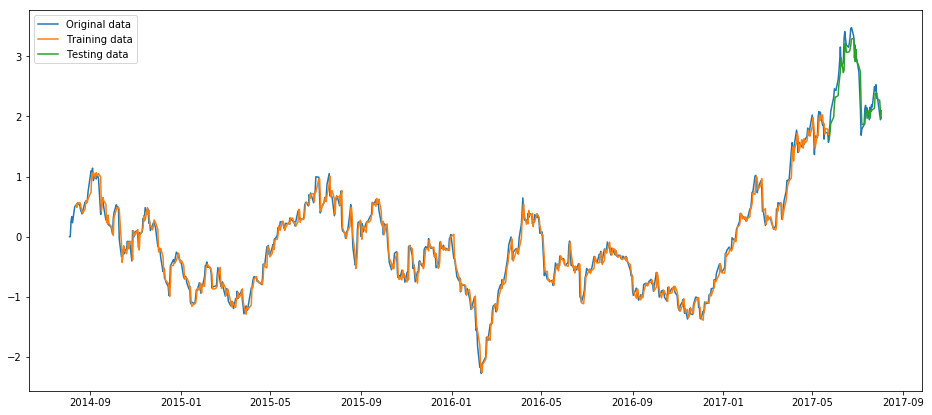

In [22]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_dataset, label='Original data')
plt.plot(tesla_stocks.Date, training, label='Training data')
plt.plot(tesla_stocks.Date, testing, label='Testing data')
plt.legend()
plt.show()